In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 40

TRAIN_DIR = "/content/drive/MyDrive/FRAI/dataset/train"
VAL_DIR = "/content/drive/MyDrive/FRAI/dataset/val"
TEST_DIR = "/content/drive/MyDrive/FRAI/dataset/test"

In [4]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary"
)

val_data = val_gen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary"
)

test_data = test_gen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=1, class_mode="binary", shuffle=False
)

Found 6984 images belonging to 2 classes.
Found 832 images belonging to 2 classes.
Found 1656 images belonging to 2 classes.


In [5]:
# 2. Class Weights
# -----------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [6]:
# 3. Load VGG16 and Fine-Tune Last Blocks
# -----------------------
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze early layers — keep last 6 trainable
for layer in base_model.layers[:-6]:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
# 4. Better Classification Head
# -----------------------
x = layers.GlobalAveragePooling2D()(base_model.output)

x = layers.Dense(
    256, activation="relu",
    kernel_regularizer=regularizers.l2(0.001)
)(x)

x = layers.Dropout(0.5)(x)

x = layers.Dense(
    64, activation="relu",
    kernel_regularizer=regularizers.l2(0.001)
)(x)

x = layers.Dropout(0.3)(x)

output = layers.Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)


In [8]:
# 5. Compile with LR Schedule
# -----------------------
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,862,529 (56.70 MB)

 Trainable params: 9,587,073 (36.57 MB)

 Non-trainable params: 5,275,456 (20.12 MB)

In [9]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

In [10]:
# 6. Training
# -----------------------
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop, lr_schedule]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 2866s 13s/step - accuracy: 0.5289 - loss: 1.1107 - val_accuracy: 0.6250 - val_loss: 0.9314 - learning_rate: 1.0000e-04
Epoch 2/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 126s 575ms/step - accuracy: 0.6492 - loss: 0.8892 - val_accuracy: 0.6382 - val_loss: 0.8373 - learning_rate: 1.0000e-04
Epoch 3/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 128s 583ms/step - accuracy: 0.7204 - loss: 0.7357 - val_accuracy: 0.7067 - val_loss: 0.7078 - learning_rate: 1.0000e-04
Epoch 4/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 126s 577ms/step - accuracy: 0.7433 - loss: 0.6597 - val_accuracy: 0.7115 - val_loss: 0.6713 - learning_rate: 1.0000e-04
Epoch 5/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 129s 585ms/step - accuracy: 0.7514 - loss: 0.6211 - val_accuracy: 0.7175 - val_loss: 0.6502 - learning_rate: 1.0000e-04
Epoch 6/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 128s 582ms/step - accuracy: 0.7488 - loss: 0.6073 - val_accuracy: 0.7067 - val_loss: 0.6679 - learning_rate: 1.0000e-04
Epoch 7/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 1

In [11]:
# 7. Evaluation
# -----------------------
test_loss, test_acc = model.evaluate(test_data)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")

1656/1656 ━━━━━━━━━━━━━━━━━━━━ 1104s 666ms/step - accuracy: 0.7712 - loss: 0.4457

Final Test Accuracy: 79.17%


In [ ]:
model.save("/content/drive/MyDrive/FRAI/vgg16_finetuned.h5")
print("Model saved successfully!")

In [13]:
y_prob = model.predict(test_data)
y_pred = (y_prob > 0.5).astype(int).flatten()
y_true = test_data.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["no_koa", "koa"]))


1656/1656 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step

Classification Report:
              precision    recall  f1-score   support

      no_koa       0.88      0.77      0.82      1017
         koa       0.69      0.82      0.75       639

    accuracy                           0.79      1656
   macro avg       0.78      0.80      0.79      1656
weighted avg       0.80      0.79      0.79      1656



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["no_koa", "koa"],
            yticklabels=["no_koa", "koa"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

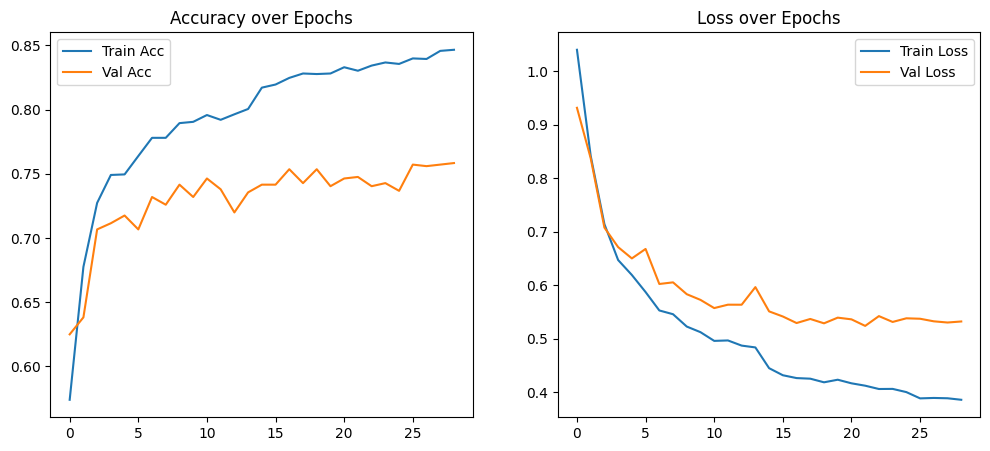

In [16]:
# Accuracy/Loss plots
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.legend()
plt.show()

In [17]:
model.save("/content/drive/MyDrive/FRAI/vgg16_finetuned.h5")
print("Model saved successfully!")

Model saved successfully!


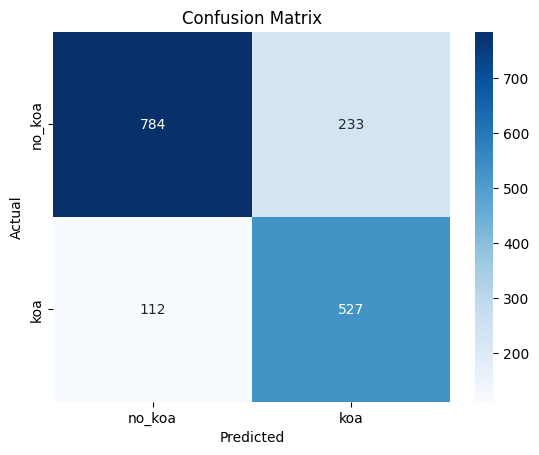

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["no_koa", "koa"],
            yticklabels=["no_koa", "koa"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()